# RQ3: Detect using custom DL models

In [1]:
from google import genai
from google.genai import types
import os
import numpy as np
import pandas as pd
import configparser
from tqdm import tqdm
import ast
import time
from vertexai.preview import tokenization

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, matthews_corrcoef, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, KFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from os import name
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, Model, Input
import numpy as np
import tensorflow.keras.backend as K

random_seed = 42

2025-03-26 00:32:34.016968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cs/grad/opumni/Research/Tangled/.conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Split train test data

In [ ]:
df_emb = pd.read_csv("./data/Embeddings/MsgDiff.csv")
df_emb["Embeddings"] = df_emb["Embeddings"].apply(ast.literal_eval)

g = pd.read_csv("./data/GoldSet.csv")
tangled_buggy = df_emb[df_emb['Hash'].isin(g['CommitHash'])]
tangled_buggy["Similarity"] = tangled_buggy["Label"].apply(lambda x: 0 if x=="NotBuggy" else 1)

true_buggy_notbuggy = df_emb[~df_emb['Hash'].isin(g['CommitHash'])]
true_buggy_notbuggy["Similarity"] = 1

df_emb = pd.concat([tangled_buggy, true_buggy_notbuggy])

dummy_x = np.arange(0,df_emb.shape[0])
dummy_df = pd.DataFrame({"X":dummy_x, "Y":df_emb["Similarity"].to_list()})
train_indx, test_indx, _, _ = train_test_split(dummy_df["X"], dummy_df["Y"], test_size=0.2, stratify=dummy_df["Y"])
train_indx.to_csv("./data/Embeddings/train_index.csv", index = False)
test_indx.to_csv("./data/Embeddings/test_index.csv", index = False)

## Gemini Embedding Collector

In [ ]:
class GeminiEmbeddingGenerator:
    def __init__(self, model_name, embedding_type):
        self.model_name = model_name
        self.embedding_type = embedding_type
        self.__setup()

    def __setup(self):
        config = configparser.ConfigParser()
        config.read(".config")
        GEMINI_API_KEY = config["API_KEYS"]["GEMINI_API_KEY"]

        self.__client = genai.Client(api_key=GEMINI_API_KEY)
        self.__tokenizer = tokenization.get_tokenizer_for_model("gemini-1.5-flash-001")
    
    def get_token_count(self, text):
        return self.__tokenizer.count_tokens(text).total_tokens 

    def get_embeddings(self, text):
        #return np.arange(1,768,1).tolist()
        result = self.__client.models.embed_content(
                        model=self.model_name ,
                        contents=text,
                        config=types.EmbedContentConfig(task_type=self.embedding_type)
                )
        return result.embeddings[0].values

## Simple classificaton task using LLM embeddings

In [ ]:
os.makedirs("./Results/RQ3/Model1", exist_ok=True)

In [2]:
df = pd.read_csv("./data/Complete_GoldSet.csv")
df['text'] = "CommitMessage: " + df['CommitMessage'] + "\nDiff:\n" +  df['Diff']

### Embedding Collection - No Need to Run

In [ ]:
egen = GeminiEmbeddingGenerator("text-embedding-004", "CLASSIFICATION")
id = []
X = []
Y = []
for _, row in tqdm(df.iterrows()):
    emb = egen.get_embeddings(row['text'])
    id.append(row["CommitHash"])
    X.append(emb)
    Y.append(row["Decision"])
    time.sleep(0.25)
df_emb = pd.DataFrame(data={"Hash": id, "Embeddings": X, "Label": Y})
df_emb['Embeddings'] = df_emb['Embeddings'].astype('object')
df_emb.to_csv("./data/Embeddings/MsgDiff.csv", index=False)

arr_x = np.array(X)
np.save("./data/Embeddings/MsgDiff.npy", arr_x)

### Training and Testing

In [2]:
df_emb = pd.read_csv("./data/Embeddings/MsgDiff.csv")
df_emb["Embeddings"] = df_emb["Embeddings"].apply(ast.literal_eval)

train_indx = pd.read_csv("./data/Embeddings/train_index.csv")["X"].to_list()
test_indx = pd.read_csv("./data/Embeddings/test_index.csv")["X"].to_list()

train = df_emb.iloc[train_indx]
test = df_emb.iloc[test_indx]

X_train = np.array([np.array(lst) for lst in train['Embeddings']])
X_test = np.array([np.array(lst) for lst in test['Embeddings']])
y_train = train['Label'].values
y_test = test['Label'].values

In [3]:
def train_test(model):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label="Buggy")
    recall = recall_score(y_test, y_pred, pos_label="Buggy")
    f1 = f1_score(y_test, y_pred, pos_label="Buggy")
    mcc = matthews_corrcoef(y_test, y_pred)

    print(type(model).__name__)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC Score: {mcc:.4f}")

    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels=["Buggy", "NotBuggy"]).plot()

#### Random Forest

RandomForestClassifier
Accuracy: 0.8159
Precision: 0.8413
Recall: 0.8196
F1 Score: 0.8303
MCC Score: 0.6294

Classification Report:
               precision    recall  f1-score   support

       Buggy       0.84      0.82      0.83       194
    NotBuggy       0.79      0.81      0.80       159

    accuracy                           0.82       353
   macro avg       0.81      0.82      0.81       353
weighted avg       0.82      0.82      0.82       353



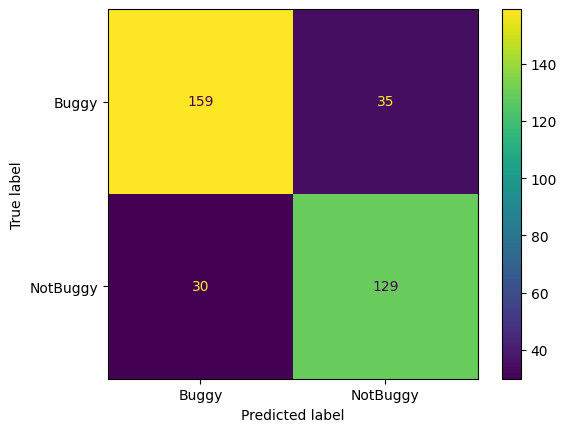

In [5]:
train_test(RandomForestClassifier(random_state=random_seed, n_jobs=-1))

#### SVC

SVC
Accuracy: 0.8839
Precision: 0.9180
Recall: 0.8660
F1 Score: 0.8912
MCC Score: 0.7684

Classification Report:
               precision    recall  f1-score   support

       Buggy       0.92      0.87      0.89       194
    NotBuggy       0.85      0.91      0.88       159

    accuracy                           0.88       353
   macro avg       0.88      0.89      0.88       353
weighted avg       0.89      0.88      0.88       353



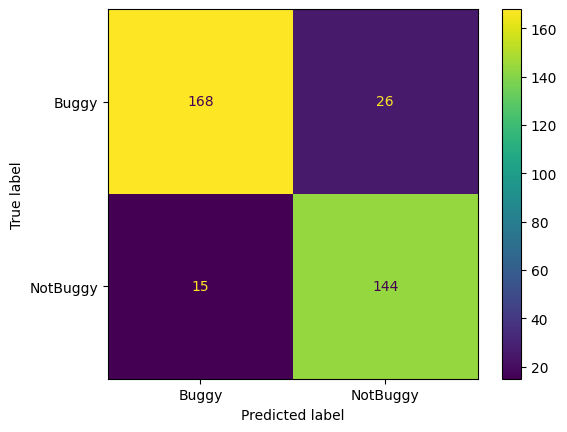

In [6]:
train_test(SVC(random_state=random_seed))

#### Decision Tree

DecisionTreeClassifier
Accuracy: 0.6856
Precision: 0.7173
Recall: 0.7062
F1 Score: 0.7117
MCC Score: 0.3660

Classification Report:
               precision    recall  f1-score   support

       Buggy       0.72      0.71      0.71       194
    NotBuggy       0.65      0.66      0.65       159

    accuracy                           0.69       353
   macro avg       0.68      0.68      0.68       353
weighted avg       0.69      0.69      0.69       353



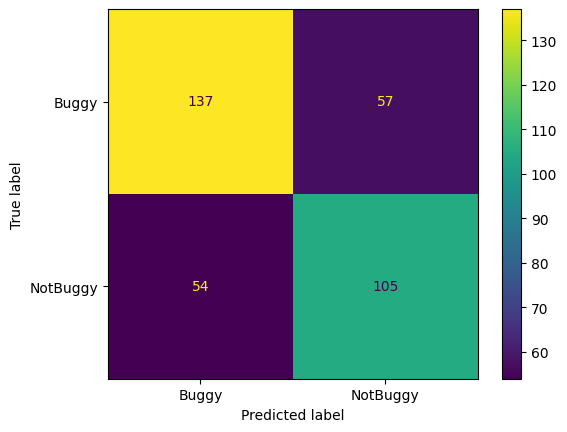

In [7]:
train_test(DecisionTreeClassifier(random_state=random_seed))

#### MLP

MLPClassifier
Accuracy: 0.8952
Precision: 0.9290
Recall: 0.8763
F1 Score: 0.9019
MCC Score: 0.7911

Classification Report:
               precision    recall  f1-score   support

       Buggy       0.93      0.88      0.90       194
    NotBuggy       0.86      0.92      0.89       159

    accuracy                           0.90       353
   macro avg       0.89      0.90      0.89       353
weighted avg       0.90      0.90      0.90       353



/home/cs/grad/opumni/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


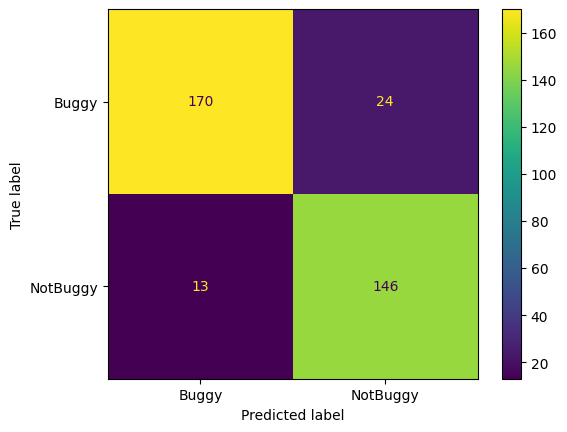

In [8]:
train_test(MLPClassifier(random_state=random_seed))

#### Leave One Out

/home/cs/grad/opumni/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 14%|█▍        | 249/1764 [30:38<3:14:20,  7.70s/it]/home/cs/grad/opumni/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 14%|█▍        | 250/1764 [30:45<3:09:36,  7.51s/it]/home/cs/grad/opumni/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 14%|█▍        | 251/1764 [30:52<3:07:43,  7.44s/it]/home/cs/grad/opumni/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

Accuracy 0.9036281179138322 
Precision 0.8980263157894737 
Recall 0.9140625 
F1 Score 0.9059734513274337 
MCC 0.8072851031361549

Classification Report:
               precision    recall  f1-score   support

       Buggy       0.90      0.91      0.91       896
    NotBuggy       0.91      0.89      0.90       868

    accuracy                           0.90      1764
   macro avg       0.90      0.90      0.90      1764
weighted avg       0.90      0.90      0.90      1764



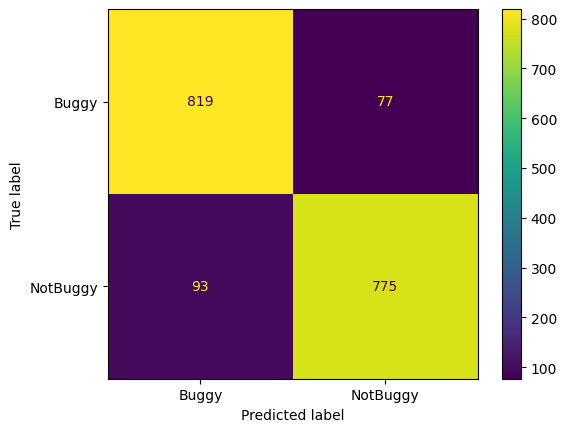

In [4]:
X = df_emb['Embeddings']
X = np.array([np.array(lst) for lst in X])

y = df_emb['Label'].values

y_preds, y_trues = [], []

cv = LeaveOneOut()
for train, test in tqdm(cv.split(X, y), total=len(X)):
    x_train = [X[i] for i in train]
    x_test = [X[test[0]]]
    y_train = [y[i] for i in train]
    y_test = [y[test[0]]]

    model = MLPClassifier(random_state=random_seed)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    y_preds.append(y_pred)
    y_trues.append(y_test[0])

print(
    "Accuracy", accuracy_score(y_trues, y_preds),
    "\nPrecision", precision_score(y_trues, y_preds, pos_label="Buggy"),
    "\nRecall", recall_score(y_trues, y_preds, pos_label="Buggy"),
    "\nF1 Score", f1_score(y_trues, y_preds, pos_label="Buggy"),
    "\nMCC", matthews_corrcoef(y_trues, y_preds),
)

print("\nClassification Report:\n", classification_report(y_trues, y_preds))
conf_matrix = confusion_matrix(y_trues, y_preds)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Buggy", "NotBuggy"]).plot()


## Multi-step Classification

### Embedding Collection - No Need to Run

In [ ]:
hashes = []
msg_cls_emb = []
msg_sim_emb = []
diff_sim_emb = []
labels = []
egen_cls = GeminiEmbeddingGenerator("text-embedding-004", "CLASSIFICATION")
egen_sim = GeminiEmbeddingGenerator("text-embedding-004", "SEMANTIC_SIMILARITY")

for _, row in tqdm(df.iterrows()):
    try:
        msg_cls_emb.append(egen_cls.get_embeddings(row['CommitMessage']))

        msg_sim_emb.append(egen_sim.get_embeddings(row['CommitMessage']))
        diff_sim_emb.append(egen_sim.get_embeddings(row['Diff']))

        hashes.append(row["CommitHash"])
        labels.append(row["Decision"])
        time.sleep(0.5)
    except Exception as e:
        print(e)
        time.sleep(30)
df_emb = pd.DataFrame(data={"Hash": hashes, "Msg_Cls_Embeddings": msg_cls_emb, "Msg_Sim_Embeddings": msg_sim_emb, "Diff_Sim_Embeddings": diff_sim_emb, "Label": labels})
df_emb.to_csv("./data/Embeddings/MsgCls_MsgDiffSim.csv", index=False)

arr_x = np.array(msg_cls_emb)
np.save("./data/Embeddings/MsgCls.npy", arr_x)
arr_x = np.array(msg_sim_emb)
np.save("./data/Embeddings/MsgSim.npy", arr_x)
arr_x = np.array(diff_sim_emb)
np.save("./data/Embeddings/DiffSim.npy", arr_x)

### Training and Testing

In [5]:
df_emb = pd.read_csv("./data/Embeddings/MsgCls_MsgDiffSim.csv")
df_emb["Msg_Cls_Embeddings"] = df_emb["Msg_Cls_Embeddings"].apply(ast.literal_eval)
df_emb["Msg_Sim_Embeddings"] = df_emb["Msg_Sim_Embeddings"].apply(ast.literal_eval)
df_emb["Diff_Sim_Embeddings"] = df_emb["Diff_Sim_Embeddings"].apply(ast.literal_eval)

g = pd.read_csv("./data/GoldSet.csv")
tangled_buggy = df_emb[df_emb['Hash'].isin(g['CommitHash'])]
tangled_buggy["Similarity"] = tangled_buggy["Label"].apply(lambda x: 0 if x=="NotBuggy" else 1)

true_buggy_notbuggy = df_emb[~df_emb['Hash'].isin(g['CommitHash'])]
true_buggy_notbuggy["Similarity"] = 1

df_emb = pd.concat([tangled_buggy, true_buggy_notbuggy])

train_indx = pd.read_csv("./data/Embeddings/train_index.csv")["X"].to_list()
test_indx = pd.read_csv("./data/Embeddings/test_index.csv")["X"].to_list()

train = df_emb.iloc[train_indx]
test = df_emb.iloc[test_indx]

/tmp/ipykernel_516249/3133759660.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tangled_buggy["Similarity"] = tangled_buggy["Label"].apply(lambda x: 0 if x=="NotBuggy" else 1)
/tmp/ipykernel_516249/3133759660.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_buggy_notbuggy["Similarity"] = 1


In [6]:
def prepare_data(msg_cls, msg_sim, diff_sum, label, similarity):
    input_data_a = np.array([np.array(lst) for lst in msg_cls.values])
    input_data_b = np.array([np.array(lst) for lst in msg_sim.values])
    input_data_c = np.array([np.array(lst) for lst in diff_sum.values])

    class_labels = [1 if x=="NotBuggy" else 0 for x in label.values]
    similarity_labels = similarity.values
    final_labels = class_labels

    input_data_a = np.array(input_data_a, dtype=np.float32)
    input_data_b = np.array(input_data_b, dtype=np.float32)
    input_data_c = np.array(input_data_c, dtype=np.float32)

    class_labels = np.array(class_labels, dtype=np.float32).reshape(-1,1)
    similarity_labels = np.array(similarity_labels, dtype=np.float32).reshape(-1,1)
    final_labels = np.array(final_labels, dtype=np.float32).reshape(-1,1)

    return input_data_a, input_data_b, input_data_c, class_labels, similarity_labels, final_labels

train_x_msg_cls, train_x_msg_sim, train_x_diff_sim, train_y_cls, train_y_sim, train_y = prepare_data(train["Msg_Cls_Embeddings"], train["Msg_Sim_Embeddings"], train["Diff_Sim_Embeddings"], train["Label"], train["Similarity"])
test_x_msg_cls, test_x_msg_sim, test_x_diff_sim, test_y_cls, test_y_sim, test_y = prepare_data(test["Msg_Cls_Embeddings"], test["Msg_Sim_Embeddings"], test["Diff_Sim_Embeddings"], test["Label"], test["Similarity"]) 

#### Define Model

In [7]:
def get_model():
    K.clear_session()
    tf.config.run_functions_eagerly(False)

    input_shape = (768,)

    # Commit Message Classification Model
    input_a = Input(shape=input_shape, name="cls_input")
    x_a = layers.Dense(512, activation='relu', name="cls_l1")(input_a)
    x_a = layers.Dense(64, activation='relu', name="cls_l2")(x_a)
    x_a = layers.Dense(32, activation='relu', name="cls_l3")(x_a)
    class_output = layers.Dense(1, activation='sigmoid', name="cls_output")(x_a)


    # Commit Message and Diff Similarity Model
    input_b = Input(shape=input_shape, name="sim_input_1")
    input_c = Input(shape=input_shape, name="sim_input_2")

    def shared_siamese_network(input_layer, name):
        x = layers.Dense(64, activation='relu', name=f"sim_{name}_1")(input_layer)
        x = layers.Dense(32, activation='relu', name=f"sim_{name}_2")(x)
        output = layers.Dense(16, activation='linear', name=f"sim_{name}_3")(x) 
        return output

    embedding_b = shared_siamese_network(input_b, "1")
    embedding_c = shared_siamese_network(input_c, "2")

    def similarity(vectors):
        x, y = vectors
        x = tf.nn.l2_normalize(x, axis=1) 
        y = tf.nn.l2_normalize(y, axis=1)
        return tf.reduce_sum(x * y, axis=1, keepdims=True)

    similarity_output = layers.Lambda(similarity, name="similarity_output")([embedding_b, embedding_c])

    final_output = layers.Multiply(name="multiply")([class_output, similarity_output])
    final_output = layers.Dense(1, activation='sigmoid', name="final_output")(final_output)

    model = Model(inputs=[input_a, input_b, input_c], outputs=[class_output, similarity_output, final_output], name="model")

    cls_layers = [model.get_layer("cls_input"), model.get_layer("cls_l1"), model.get_layer("cls_l2"), model.get_layer("cls_l3"), model.get_layer("cls_output")]
    sim_layers = [model.get_layer("sim_input_1"), model.get_layer("sim_input_2"), 
                model.get_layer("sim_1_1"), model.get_layer("sim_1_2"), model.get_layer("sim_1_3"),
                model.get_layer("sim_2_1"), model.get_layer("sim_2_2"), model.get_layer("sim_2_3"),
                model.get_layer("similarity_output")
                ]
    final_layers = [model.get_layer("multiply"), model.get_layer("final_output")]

    optimizers_and_layers = [(tf.keras.optimizers.Adam(learning_rate=0.001), cls_layers),
                            (tf.keras.optimizers.SGD(learning_rate=0.01), sim_layers),
                            (tf.keras.optimizers.Adam(learning_rate=0.001), final_layers)]

    # Losses
    losses = {
        "cls_output":  tf.keras.losses.BinaryCrossentropy(from_logits=False),
        "similarity_output": "mse",
        "final_output":  tf.keras.losses.BinaryCrossentropy(from_logits=False)  
    }

    # Metrics
    metrics = {
        "cls_output": "accuracy",
        "similarity_output": "mae",
        "final_output": "accuracy"
    }

    optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)
    model.compile(
        optimizer=optimizer,
        loss=losses,
        metrics=metrics
    )

    return model


#### Train

In [20]:
model = get_model()
history = model.fit(
    [train_x_msg_cls, train_x_msg_sim, train_x_diff_sim], 
    {
        "cls_output": train_y_cls, 
        "similarity_output": train_y_sim, 
        "final_output": train_y
    }, 
    epochs=25, 
    batch_size=8,
    verbose=False
)

In [23]:
output_cls, output_sim, output = model.predict([test_x_msg_cls, test_x_msg_sim, test_x_diff_sim])
y_pred = (output >= 0.5).astype(int)

y_test = test_y

12/12 [==============================] - 0s 2ms/step


Accuracy: 0.9065
Precision: 0.9045
Recall: 0.9278
F1 Score: 0.9160
MCC Score: 0.8110

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       194
         1.0       0.91      0.88      0.89       159

    accuracy                           0.91       353
   macro avg       0.91      0.90      0.91       353
weighted avg       0.91      0.91      0.91       353



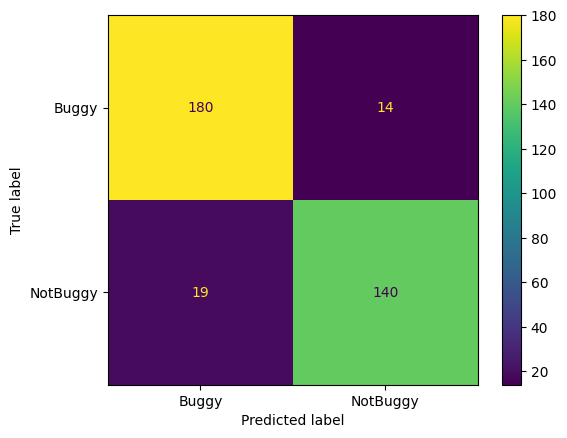

In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, pos_label=0)
mcc = matthews_corrcoef(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Buggy", "NotBuggy"]).plot()

#### Leave one out

In [8]:
y_preds, y_trues = [], []

cv = LeaveOneOut()
for train_indx, test_indx in tqdm(cv.split(df_emb), total=df_emb.shape[0]):
    train = df_emb.iloc[train_indx]
    test = df_emb.iloc[test_indx]

    train_x_msg_cls, train_x_msg_sim, train_x_diff_sim, train_y_cls, train_y_sim, train_y = prepare_data(train["Msg_Cls_Embeddings"], train["Msg_Sim_Embeddings"], train["Diff_Sim_Embeddings"], train["Label"], train["Similarity"])
    test_x_msg_cls, test_x_msg_sim, test_x_diff_sim, test_y_cls, test_y_sim, test_y = prepare_data(test["Msg_Cls_Embeddings"], test["Msg_Sim_Embeddings"], test["Diff_Sim_Embeddings"], test["Label"], test["Similarity"]) 

    model = get_model()
    history = model.fit([train_x_msg_cls, train_x_msg_sim, train_x_diff_sim], 
                        {
                            "cls_output": train_y_cls, 
                            "similarity_output": train_y_sim, 
                            "final_output": train_y
                        }, 
                        epochs=25, 
                        batch_size=8,
                        verbose = False
                    )
    output_cls, output_sim, output = model.predict([test_x_msg_cls, test_x_msg_sim, test_x_diff_sim], verbose=False)
    y_pred = (output >= 0.5).astype(int)

    y_test = test_y
    
    y_preds.append(y_pred)
    y_trues.append(y_test[0])

print(
    "Accuracy", accuracy_score(y_trues, y_preds),
    "\nPrecision", precision_score(y_trues, y_preds, pos_label=0),
    "\nRecall", recall_score(y_trues, y_preds, pos_label=0),
    "\nF1 Score", f1_score(y_trues, y_preds, pos_label=0),
    "\nMCC", matthews_corrcoef(y_trues, y_preds),
)

print("\nClassification Report:\n", classification_report(y_trues, y_preds))
conf_matrix = confusion_matrix(y_trues, y_preds)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Buggy", "NotBuggy"]).plot()


  0%|          | 4/1764 [01:26<10:34:41, 21.64s/it]

  0%|          | 5/1764 [01:47<10:33:32, 21.61s/it]

  5%|▍         | 85/1764 [30:55<10:10:49, 21.83s/it]


KeyboardInterrupt: 